80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step


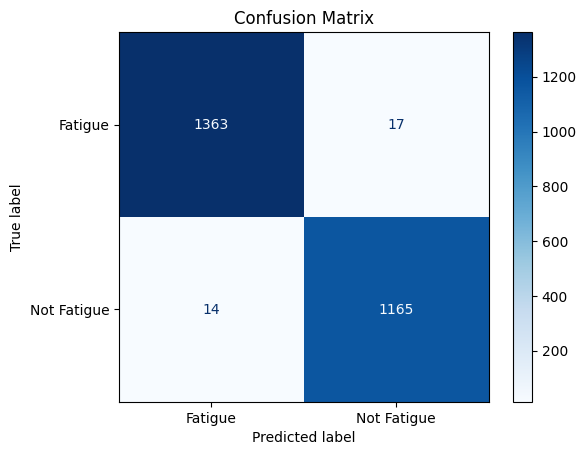

              precision    recall  f1-score   support

     Fatigue       0.99      0.99      0.99      1380
 Not Fatigue       0.99      0.99      0.99      1179

    accuracy                           0.99      2559
   macro avg       0.99      0.99      0.99      2559
weighted avg       0.99      0.99      0.99      2559



In [3]:
import os, cv2, numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Constants
DATASET_DIR = 'ProcessedFusionFull'
CLASSES = ['Fatigue', 'Not Fatigue']
IMG_SIZE = 256
landmark_dim = 478 * 2

# Load data
X_face, X_dot, X_lmk, y = [], [], [], []
for label, cls in enumerate(CLASSES):
    face_path = os.path.join(DATASET_DIR, cls, 'face')
    dot_path = os.path.join(DATASET_DIR, cls, 'dotmap')
    lmk_path = os.path.join(DATASET_DIR, cls, 'landmark')

    for fname in os.listdir(face_path):
        base = os.path.splitext(fname)[0]
        face_file = os.path.join(face_path, base + '.png')
        dot_file  = os.path.join(dot_path, base + '.png')
        lmk_file  = os.path.join(lmk_path, base + '.npy')

        if not (os.path.exists(face_file) and os.path.exists(dot_file) and os.path.exists(lmk_file)):
            continue

        face = cv2.imread(face_file, cv2.IMREAD_GRAYSCALE)
        dot  = cv2.imread(dot_file,  cv2.IMREAD_GRAYSCALE)
        lmk  = np.load(lmk_file)

        if face is None or dot is None or lmk.shape[0] != 478:
            continue

        face = cv2.resize(face, (IMG_SIZE, IMG_SIZE)) / 255.0
        dot  = cv2.resize(dot,  (IMG_SIZE, IMG_SIZE)) / 255.0

        X_face.append(face[..., np.newaxis])
        X_dot.append(dot[..., np.newaxis])
        X_lmk.append(lmk.flatten())
        y.append(label)

# Convert to numpy arrays
X_face = np.array(X_face, dtype=np.float32)
X_dot  = np.array(X_dot, dtype=np.float32)
X_lmk  = np.array(X_lmk, dtype=np.float32)
y      = np.array(y, dtype=np.float32)

# Split
_, Xf_val, _, Xd_val, _, Xm_val, _, y_val = train_test_split(
    X_face, X_dot, X_lmk, y, test_size=0.1, stratify=y, random_state=42
)

# Load model
model = tf.keras.models.load_model('fatigue_fusion_model_generator_70.h5')

# Predict
y_pred = model.predict([Xf_val, Xd_val, Xm_val])
y_pred_cls = (y_pred > 0.5).astype(int).flatten()

# Evaluate
cm = confusion_matrix(y_val, y_pred_cls)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Report
print(classification_report(y_val, y_pred_cls, target_names=CLASSES))
